# Predict Bike Sharing Demand with AutoGluon Template

### Install packages

In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
!pip install -U kaggle
# Without --no-cache-dir, smaller aws instances may have trouble installing

  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached bokeh-2.0.1-py3-none-any.whl
  Using cached graphviz-0.8.4-py2.py3-none-any.whl.metadata (6.4 kB)
Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl (49.1 MB)
Using cached graphviz-0.8.4-py2.py3-none-any.whl (16 kB)
  Attempting uninstall: bokeh
    Found existing installation: bokeh 3.4.1
    Uninstalling bokeh-3.4.1:
      Successfully uninstalled bokeh-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 1.4.1 requires bokeh<3.5.0,>=3.4.0, but you have bokeh 2.0.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 269.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 178.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 253.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

### Setup Kaggle API Key

In [3]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "danielpmathews"
kaggle_key = "6b4d5550ca29d4bf26a121eacdeeb293"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms
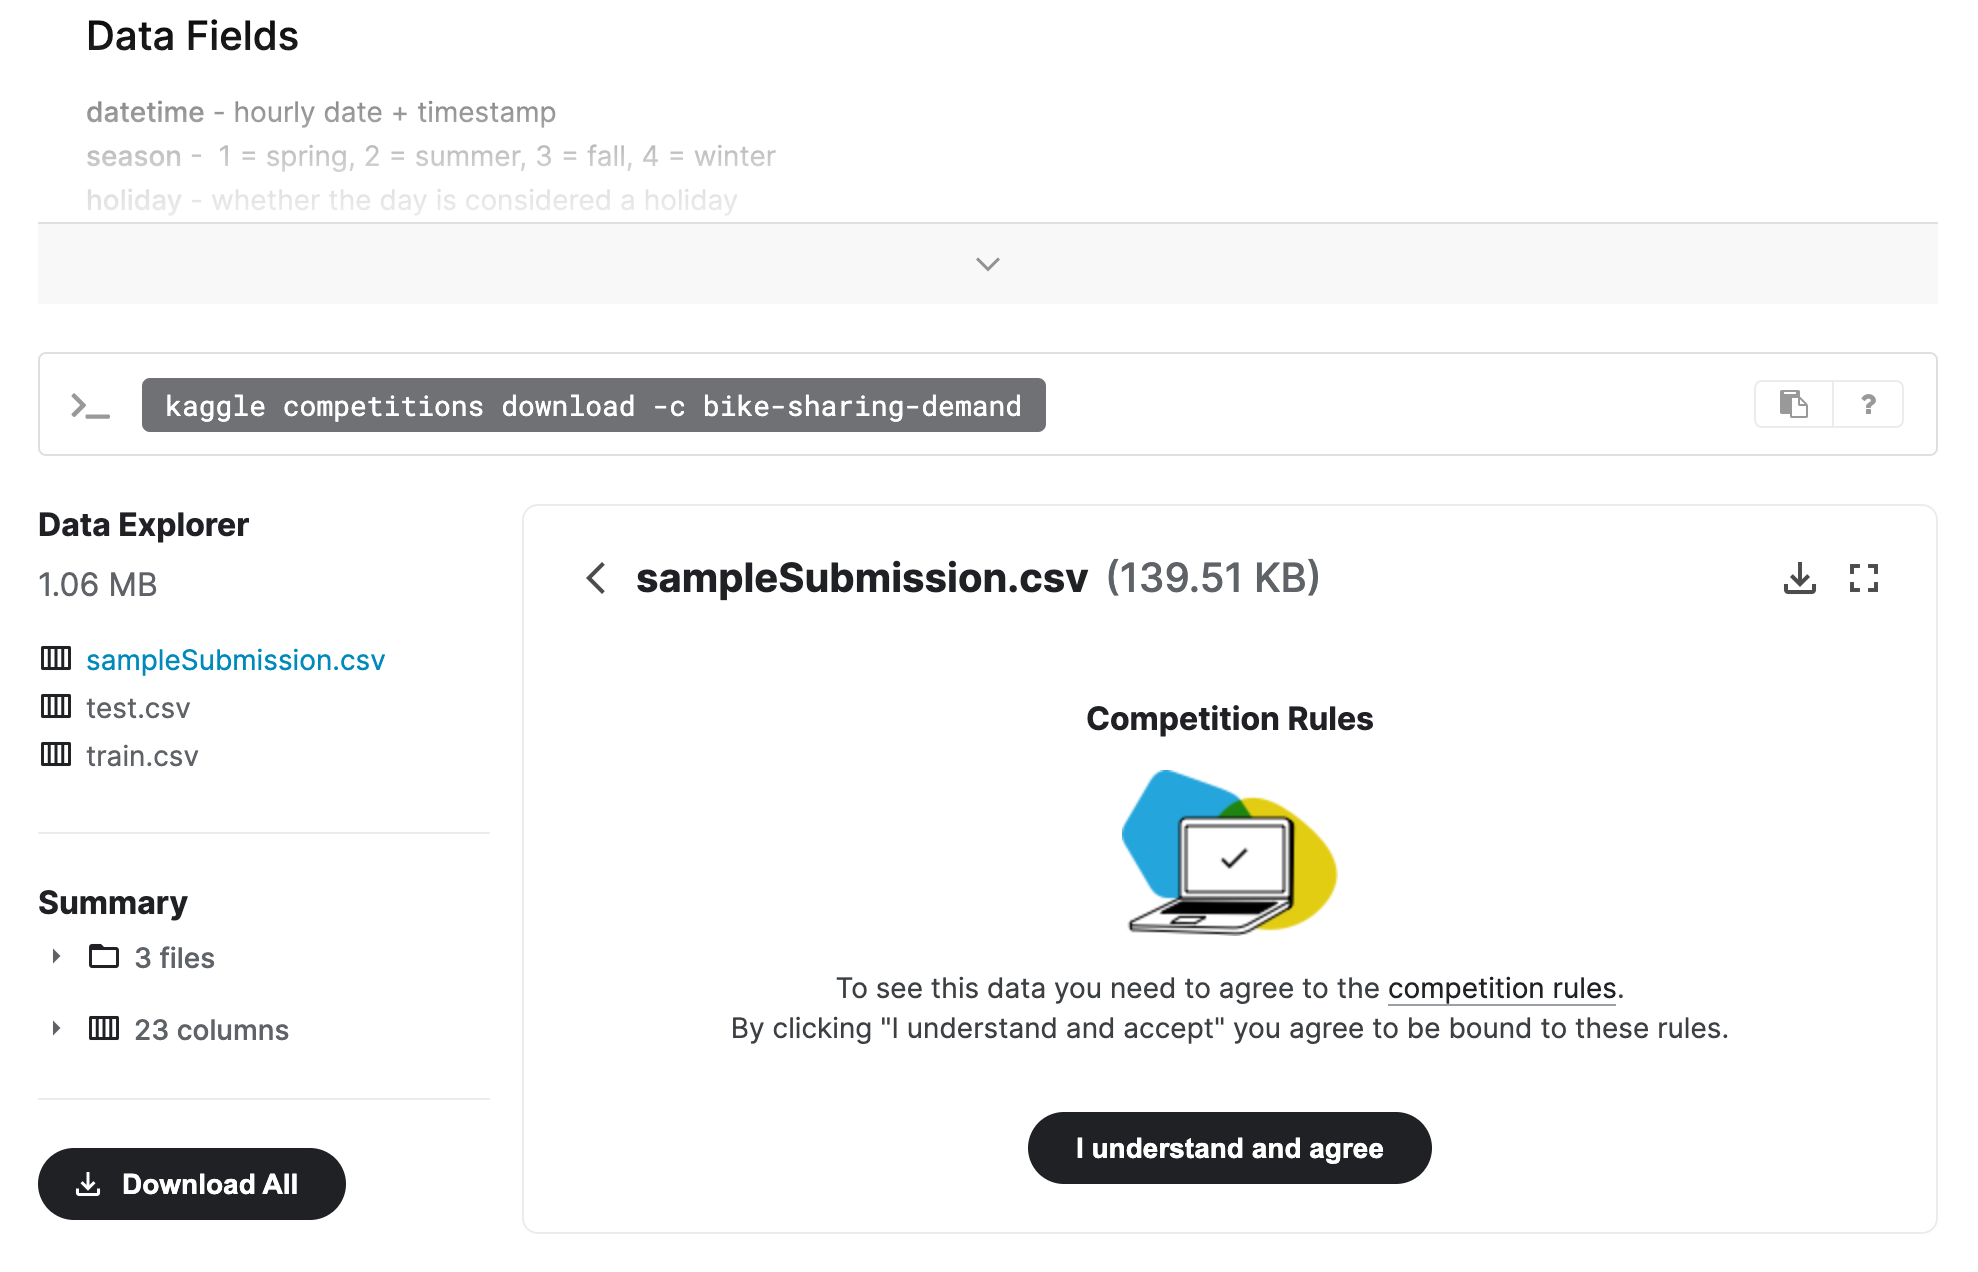

In [10]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

  0%|                                                | 0.00/189k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 189k/189k [00:00<00:00, 5.33MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [11]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [66]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv',parse_dates=['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.

In [65]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv',parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [21]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv',parse_dates=['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [36]:
predictor = TabularPredictor(label='count',eval_metric='root_mean_squared_error',learner_kwargs={'ignored_columns': ['casual','registered']}).fit(train,presets='best_quality',time_limit=600)

No path specified. Models will be saved in: "AutogluonModels/ag-20240506_212412"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240506_212412/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 242 seconds

### Review AutoGluon's training run with ranking of models that did the best.

In [ ]:
predictor.fit_summary()

### Create predictions from test dataset

In [38]:
predictions = predictor.predict(test)
predictions.head()

0    23.473831
1    43.636467
2    46.724686
3    49.557301
4    52.038204
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [45]:
# Describe the `predictions` series to see if there are any negative values


In [54]:
# How many negative values do we have?
(predictions<0).sum()

0

In [55]:
# Set them to zero
predictions[predictions<0] = 0

### Set predictions to submission dataframe, save, and submit

In [56]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [57]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 671kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [58]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description           status   publicScore  privateScore  
--------------  -------------------  --------------------  -------  -----------  ------------  
submission.csv  2024-05-06 22:05:29  first raw submission  pending                             


#### Initial score of `?`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'holiday'}>],
       [<Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'weather'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>]], dtype=object)

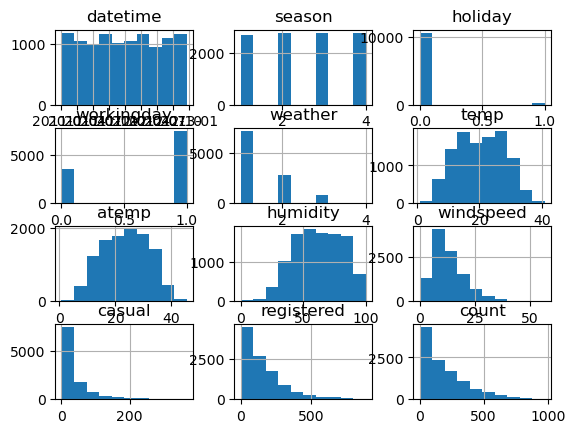

In [61]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist()

In [67]:
# create a new feature
train['hour'] = train['datetime'].dt.hour
test['hour'] = test['datetime'].dt.hour

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [68]:
train["season"] = train["season"].astype('category')
train["weather"] = train["weather"].astype('category')
test["season"] = test["season"].astype('category')
test["weather"] = test["weather"].astype('category')

In [69]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>],
       [<Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>],
       [<Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>],
       [<Axes: title={'center': 'count'}>,
        <Axes: title={'center': 'hour'}>, <Axes: >]], dtype=object)

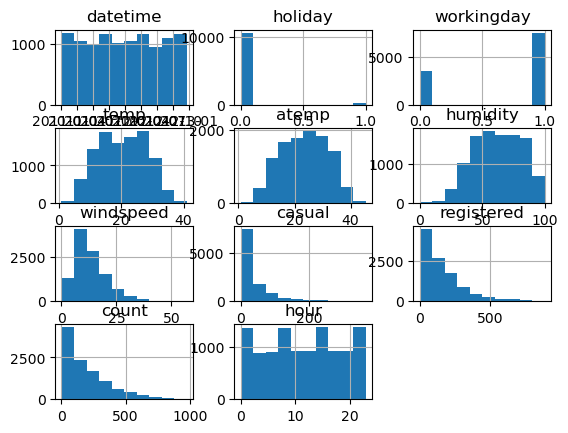

In [71]:
# View histogram of all features again now with the hour feature
train.hist()

## Step 5: Rerun the model with the same settings as before, just with more features

In [72]:
predictor_new_features = TabularPredictor(label='count',eval_metric='root_mean_squared_error',learner_kwargs={'ignored_columns': ['casual','registered']}).fit(train,presets='best_quality',time_limit=600)

No path specified. Models will be saved in: "AutogluonModels/ag-20240506_224326"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240506_224326/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 169 seconds

In [73]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.378655  root_mean_squared_error      22.079897  382.990223                0.003488           0.041605            3       True         12
1          LightGBM_BAG_L2  -30.613565  root_mean_squared_error      19.635808  298.408272                0.446312          32.983774            2       True         10
2        LightGBMXT_BAG_L2  -31.233574  root_mean_squared_error      20.669990  303.997786                1.480494          38.573288            2       True          9
3   RandomForestMSE_BAG_L2  -31.751194  root_mean_squared_error      20.149603  311.391556                0.960107          45.967058            2       True         11
4      WeightedEnsemble_L2  -32.297459  root_mean_squared_error      18.442334  258.387807   

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -34.457273921492806,
  'LightGBM_BAG_L1': -33.919639163586254,
  'RandomForestMSE_BAG_L1': -38.4543378929385,
  'CatBoost_BAG_L1': -34.97211724996638,
  'ExtraTreesMSE_BAG_L1': -38.326129123608844,
  'WeightedEnsemble_

In [82]:
# Remember to set all negative values to zero
print((predictions<0).sum())
predictions[predictions<0] = 0

0


In [79]:
# Same submitting predictions
submission_new_features = pd.read_csv('sampleSubmission.csv',parse_dates=['datetime'])
submission_new_features["count"] = predictions
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [80]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 706kB/s]
Successfully submitted to Bike Sharing Demand

In [81]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features.csv  2024-05-06 23:00:59  new features          complete  1.80175      1.80175       
submission.csv               2024-05-06 22:05:29  first raw submission  complete  1.80175      1.80175       


#### New Score of `?`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [ ]:
predictor_new_hpo = TabularPredictor(label='count',eval_metric='root_mean_squared_error',learner_kwargs={'ignored_columns': ['casual','registered']}).fit(train,presets='best_quality',time_limit=600)

In [ ]:
predictor_new_hpo.fit_summary()

In [ ]:
# Remember to set all negative values to zero
?

In [ ]:
# Same submitting predictions
submission_new_hpo["count"] = ?
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

#### New Score of `?`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

In [ ]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [?, ?, ?]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

In [ ]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [?, ?, ?]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [ ]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": [?, ?, ?],
    "hpo2": [?, ?, ?],
    "hpo3": [?, ?, ?],
    "score": [?, ?, ?]
})